# Carga, tratamiento y preparación de los datos 

### Requisitos del sistema: 

In [7]:
import re
import warnings
from json import dumps, loads
from pathlib import Path

import matplotlib as plt
import missingno as msno
import numpy as np
import pandas as pd
from fuzzywuzzy import process

warnings.filterwarnings("ignore")

from utils.endpoints import get_lat_lng, save_data_to_json_file
from utils.nationality_mapper import NationalityMapper

mapper = NationalityMapper()

### Carga de los datos

Se opta por cargar y guardar los datos en formato feather, puesto que este formato es el más liviano entre aquellos disponibles para almacenamiento de dataframes. Fuente: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d

In [8]:
data_path = Path('./data/met_object.feather')

In [9]:
# Para evitar descargar los datos si ya se tienen. 
if not data_path.exists():
    # Si el archivo no existe, descarga y guarda
    save_data_to_json_file('./data/met_object.json')
    data = pd.read_json('./data/met_object.json')
else:
    # Si el archivo ya existe, omite la descarga
    print('Skipping data download')
    data = pd.read_feather('./data/met_object.feather')

Skipping data download


In [10]:
# Reemplazo valores vacíos y espacios en blanco por NaN
data = data.replace('', np.nan)
data = data.replace(' ', np.nan)

In [11]:
# Dimensión del dataset
data.shape

(484956, 54)

In [12]:
data.dtypes

objectNumber             object
isHighlight               object
isTimelineWork            object
isPublicDomain            object
objectID                   int64
galleryNumber             object
department                object
accessionYear             object
objectName                object
title                     object
culture                   object
period                    object
dynasty                   object
reign                     object
portfolio                 object
constituentID             object
artistRole                object
artistPrefix              object
artistDisplayName         object
artistDisplayBio          object
artistSuffix              object
artistAlphaSort           object
artistNationality         object
artistBeginDate           object
artistEndDate             object
artistGender              object
artistUlanUrl             object
artistWikidataUrl         object
objectDate                object
objectBeginDate            int64
objectEndDa

In [13]:
# Para mejorar la visualizacion de todas las columnas, imprimo de forma transpuesta el dataset para dos registros aleatorios
data.sample(2).T

,249861,225180
﻿objectNumber,41.1.220,52.519.74
isHighlight,False,False
isTimelineWork,False,False
isPublicDomain,True,False
objectID,382479,356627
galleryNumber,NaN,NaN
department,Drawings and Prints,Drawings and Prints
accessionYear,1941,1952
objectName,Print,Book ; facsimile
title,Virgin and Child,Modèles de Dessins D'Orfèvrerie


In [14]:
# Verifico la existencia de valores null 
data.isnull().values.any()

True

In [15]:
# Reviso la ubicación de los valores null
def get_cols_missing_val(df):
    cols_missing_val = df.columns[df.isnull().any()].tolist()
    return cols_missing_val
get_cols_missing_val(data)

['galleryNumber',
 'accessionYear',
 'objectName',
 'title',
 'culture',
 'period',
 'dynasty',
 'reign',
 'portfolio',
 'constituentID',
 'artistRole',
 'artistPrefix',
 'artistDisplayName',
 'artistDisplayBio',
 'artistSuffix',
 'artistAlphaSort',
 'artistNationality',
 'artistBeginDate',
 'artistEndDate',
 'artistGender',
 'artistUlanUrl',
 'artistWikidataUrl',
 'objectDate',
 'medium',
 'dimensions',
 'creditLine',
 'geographyType',
 'city',
 'state',
 'county',
 'country',
 'region',
 'subregion',
 'locale',
 'locus',
 'excavation',
 'river',
 'classification',
 'rightsAndReproduction',
 'objectWikidataUrl',
 'metadataDate',
 'tags',
 'tagsAatUrl',
 'tagsWikiUrl']

In [16]:
# Porcentaje de valores null en cada variable
def calculate_missing_percentage(df):
    cols_missing_val_percentage = {}
    cols_missing_val = get_cols_missing_val(df)
    for col in cols_missing_val:
        percentage = (df[col].isnull().sum())
        dimension = len(df)
        final_percentage = round((percentage/dimension)*100,4)
        cols_missing_val_percentage[col] = final_percentage
    return  cols_missing_val_percentage        

In [17]:
calculate_missing_percentage(data)

{'galleryNumber': 89.7844,
 'accessionYear': 0.7964,
 'objectName': 0.4673,
 'title': 5.9106,
 'culture': 57.0703,
 'period': 81.2059,
 'dynasty': 95.2159,
 'reign': 97.6831,
 'portfolio': 94.5327,
 'constituentID': 41.7446,
 'artistRole': 41.7446,
 'artistPrefix': 71.989,
 'artistDisplayName': 41.7446,
 'artistDisplayBio': 49.4272,
 'artistSuffix': 78.988,
 'artistAlphaSort': 41.7607,
 'artistNationality': 47.1082,
 'artistBeginDate': 41.7446,
 'artistEndDate': 41.7446,
 'artistGender': 78.043,
 'artistUlanUrl': 53.1007,
 'artistWikidataUrl': 53.7686,
 'objectDate': 2.7695,
 'medium': 1.4876,
 'dimensions': 15.4771,
 'creditLine': 0.1342,
 'geographyType': 87.6362,
 'city': 93.246,
 'state': 99.4595,
 'county': 98.2351,
 'country': 84.327,
 'region': 93.5046,
 'subregion': 95.434,
 'locale': 96.7546,
 'locus': 98.4498,
 'excavation': 96.583,
 'river': 99.5686,
 'classification': 16.2318,
 'rightsAndReproduction': 94.942,
 'objectWikidataUrl': 85.7401,
 'metadataDate': 100.0,
 'tags': 

### Análisis de valores null en cada variable

No es inesperado que que las columnas de 'artistDisplayName' y 'country'' tengan valores nulos, porque en el sector artístico es común que hayan obras con artistas anónimos. 

In [18]:
# Se decide imputar los valores faltantes de country por Unknown 
data['country'].fillna('Unknown', inplace = True)
# Se decide imputar los valores faltantes de artistDisplyName por Anonymous
data['artistDisplayName'].fillna('Anonymous', inplace = True)

La mayoría de las columnas del dataset están predominantemente vacías. 
Para enriquecerlo, sería útil mezclar con otra fuente de datos, sin embargo, según la búsqueda realizada, los demás museos del mundo que disponen de API solo incluyen su colección en la BD y por obvias razones, una misma obra, no puede estar en dos museos a la vez. 
Por esta razón, se opta por centrar el proyecto en aquellos atributos de los que no exceden el 60% de nulidad. 

In [19]:
# Aquellas cuyo porcentaje de nulidad exceda al 60%, se eliminarán del estudio.
cols_missing_val_percentage = calculate_missing_percentage(data)
for col, percentage in cols_missing_val_percentage.items():
    if percentage >= 60:
        print(f'Se elimina la columna {col}')
        data = data.drop(col, axis=1)

Se elimina la columna galleryNumber
Se elimina la columna period
Se elimina la columna dynasty
Se elimina la columna reign
Se elimina la columna portfolio
Se elimina la columna artistPrefix
Se elimina la columna artistSuffix
Se elimina la columna artistGender
Se elimina la columna geographyType
Se elimina la columna city
Se elimina la columna state
Se elimina la columna county
Se elimina la columna region
Se elimina la columna subregion
Se elimina la columna locale
Se elimina la columna locus
Se elimina la columna excavation
Se elimina la columna river
Se elimina la columna rightsAndReproduction
Se elimina la columna objectWikidataUrl
Se elimina la columna metadataDate
Se elimina la columna tags
Se elimina la columna tagsAatUrl
Se elimina la columna tagsWikiUrl


Dadas las características del Dataset, se decide enfocar los objetivos del proyecto con las siguientes preguntas:
1. ¿De dónde provienen las obras de arte del MET?
2. ¿Qué artistas le interesan al MET?
3. ¿Qué departamento tiene el mayor número de piezas?
4. ¿Qué culturas le interesan al MET?
5. ¿Cuál es la evolución temporal del número de obras en la colección del MET?
6. ¿Cuáles son las obras más importantes del MET?
7. ¿Qué porción de las obras de arte del MET son de dominio público?

In [20]:
# Hago una selección directa de las columnas que responden a los objetivos del proyecto y guardo en un nuevo dataset
filtered_columns = ['objectID', 'isHighlight', 'accessionYear', 'isPublicDomain', 'department', 'title', 'country',
                    'artistDisplayName', 'artistNationality', 'culture', 'classification']

filtered_data = data[filtered_columns]

In [21]:
calculate_missing_percentage(filtered_data)

{'accessionYear': 0.7964,
 'title': 5.9106,
 'artistNationality': 47.1082,
 'culture': 57.0703,
 'classification': 16.2318}

In [22]:
# La columna accessionYear tiene menos de 1% de missing values. Se opta por eliminar los registros que no tienen dato en este atributo. 
filtered_data.dropna(subset = ['accessionYear'], inplace = True)

In [23]:
# Se analiza la correlación de las demás variables que tienen valores nulos
cols_missing_val = filtered_data.columns[filtered_data.isnull().any()].tolist()
df_missing_data = filtered_data[cols_missing_val].copy()
df_missing_data.isnull().corr()

,title,artistNationality,culture,classification
title,1.000000,0.185855,-0.288463,-0.109700
artistNationality,0.185855,1.000000,-0.508066,0.157922
culture,-0.288463,-0.508066,1.000000,-0.167600
classification,-0.109700,0.157922,-0.167600,1.000000


ValueError: could not convert string to float: '--'

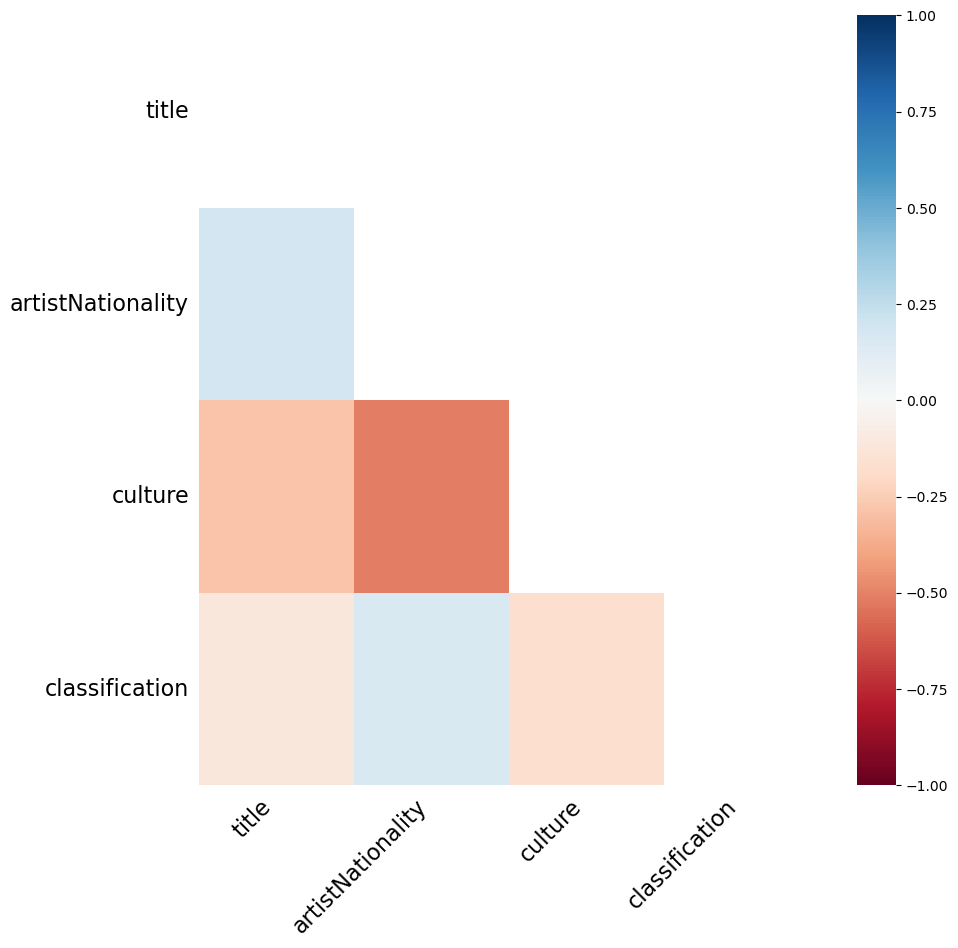

In [24]:
# Lo anterior, representado visualmente sería: 
msno.heatmap(filtered_data[cols_missing_val],figsize=(10,10))

No se evidencian correlaciones muy fuertes. Se opta por analizar la distribución y ubicación de los valores nulos que permita entender mejor esta información faltante

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

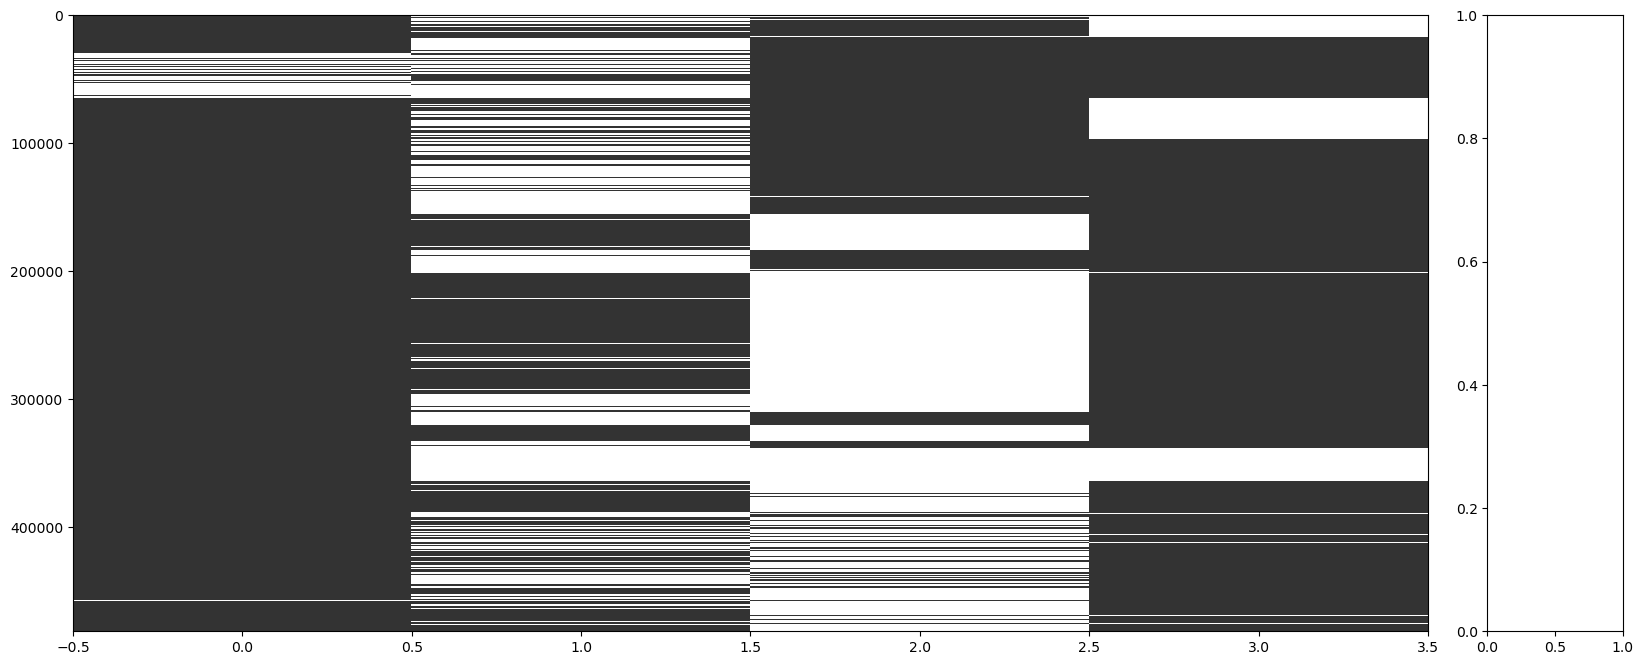

In [25]:
msno.matrix(filtered_data[cols_missing_val],width_ratios=(10,1),\
            figsize=(20,8),color=(0.2,0.2,0.2),fontsize=18,sparkline=True,labels=True)

No es extraño que el dataset tenga valores faltantes en title, porque existen en el sector obras artísticas sin titulo. Esta infromación se valido con la Casa de subastas Real de España. 

In [27]:
# Para manipular el dataset sin valores faltantes, imputo todo lo nulo con "Unknown".
for col in cols_missing_val:
    filtered_data[col].fillna('Unknown', inplace = True)

In [28]:
filtered_data.dtypes 

objectID              int64
isHighlight          object
accessionYear        object
isPublicDomain       object
department           object
title                object
country              object
artistDisplayName    object
artistNationality    object
culture              object
classification       object
dtype: object

Las columnas no tienen un tipo de dato correspondiente a la información que representan. Por lo tanto, se procede a la transformación de los tipos de datos correspondientes.

In [29]:
df = filtered_data.copy()
# Se define un diccionario que mapea los strings a su valor booleano.
mapping = {'True': True, 'False': False}

# Mapea los valores de las columnas isHighlight y isPublicDomain para poder convertirlas a boolean.
df['isHighlight'] = df['isHighlight'].map(mapping)
df['isPublicDomain'] = df['isPublicDomain'].map(mapping)

# Se parsean el resto de las variables a tipo string.
df = df.astype({'department': 'string', 'title': 'string', 'artistDisplayName': 'string', 'artistNationality': 'string', 'culture': 'string', 'classification': 'string'})

Se identifica que en la columna accessionYear contiene valores que no corresponden netamente al año (Ej. 2005-10-02), por lo que no es posible realizar el parseo directo a integer. En este sentido, se decide transformar estos datos para quedarse únicamente con el año.

In [30]:
# Convierte la columna a string para poder realizar el slice y obtener los 4 primeros caracteres.
df = df.astype({'accessionYear': 'string'})
df['accessionYear'] = df['accessionYear'].str.slice(0, 4)

# Cambio de la columna a entero.
df = df.astype({'accessionYear': 'int64'})

In [31]:
df['country'].unique().tolist()

['Unknown',
 'Mexico',
 'Guatemala',
 'United States',
 'England',
 'Spain',
 'United States|England',
 'Netherlands',
 'United States|United States',
 'France',
 'Canada',
 'United States|France',
 'England|France',
 'China',
 'Italy',
 'Germany',
 'Japan',
 'Netherlands|Netherlands',
 'Czech Republic',
 'England|Ireland',
 'Ireland|United States',
 'Venezuela',
 'England|Netherlands',
 'England|Belgium',
 'France|Italy',
 'Bermuda',
 'Ireland',
 'India',
 'England|United States',
 'United States|United States|United States',
 'France|NEW ZEALAND ROTORUA WHAKAREWAREWA',
 'China|NEW ZEALAND ROTORUA WHAKAREWAREWA',
 'Germany|Italy',
 'Lisez et propagez nos Annales: "L\'Immacul‚e"',
 'Czech Republic|England',
 'Belgium|France',
 'Belgium|England|France',
 'United States|Germany',
 'United Kingdom',
 'France|Germany',
 'Scotland',
 'Germany|Czech Republic',
 'Holland',
 'England|England',
 'United States|Denmark',
 'Finland|Denmark|United States',
 'United States|China',
 'China|India',
 

In [32]:
df['artistNationality'].unique().tolist()

['American',
 'Unknown',
 'American| ',
 'French',
 'American|American',
 'German (Stuttgart, principality of Württemberg)',
 'American, born Scotland',
 ' |American',
 'American|American|American',
 'American|American|American|American|American',
 ' | ',
 'Italian',
 'British',
 'American|British',
 'British|American',
 'American|American, born England',
 'American, born Japan|American',
 ' | |American|American',
 'American|American| ',
 'American, born Germany',
 'British, Scottish',
 'Italian|British',
 'American, born Scotland|American',
 'American|American, born Scotland',
 'American| | ',
 'American| |American',
 ' | |American',
 ' |American|American',
 'German',
 'British|British',
 'Dutch| ',
 ' |Dutch',
 'French|American',
 'American|American and French',
 ' |German',
 'German (Prussian)',
 'American, born Germany|American',
 ' |British',
 'French|French',
 'American, born Lithuania',
 'French|British, Scottish',
 'Mexican',
 'American, born England|American',
 'American|Ameri

De acuerdo con el datacard de la API, los atributos ‘country’ y ‘artistNationality’ responden de diferente forma a una misma pregunta: País de origen de la obra o el artista. El análisis exploratorio de los datos mostró que, en muchos casos, los valores faltantes de ‘country’ estaban en ‘artistNationality’, y viceversa. 

Con el objetivo de unificar la información y, por ende, enriquecerla, se construyó una clase ‘NationalityMapper’ compuesta por dos diccionarios, que permitió mapear las nacionalidades a los países y, a su vez, normalizar los nombres de los países

Debido a que una obra puede pertenecer a varios artistas, y cada artista puede tener una nacionalidad distinta, se decide que la obra será de la nacionalidad predominante de los artistas involucrados. Si no existe una nacionalidad predominante, se imputa como 'Otro'

In [33]:
# Función que extrae la nacionalidad de cada artista.
def extract_first_nationality(artist_nationalities):
    artist_nationalities_list = artist_nationalities.split("\|")
    first_nationalities = []
    for nationality in artist_nationalities_list:
        first_nationality = nationality.replace(",", " ").split(" ")[0].strip()
        first_nationalities.append(first_nationality)
    return "|".join(first_nationalities)


In [34]:
# Función que mapea la nacionalidad a su país correspondiente.
def map_to_country(nationality):
    return mapper.get_country_by_nationality(nationality)

In [35]:

# Aplicar la función de extracción de nacionalidad a la columna artist_Nationality
df['first_nationalities'] = df['artistNationality'].apply(extract_first_nationality)

# Aplicar la función de mapeo de nacionalidad a la columna país.
df['artistCountry'] = df['first_nationalities'].apply(lambda x: "|".join(map(map_to_country, x.split("|"))))

In [36]:
# Función que determina el país prevalente.
def determine_prevalent_country(country_counts):
   max_count = max(country_counts.values())
   max_countries = [country for country, count in country_counts.items() if count == max_count]
   if len(max_countries) == 1:
       return max_countries[0]
   elif len(max_countries) > 1:
       return 'Other'
   else:
       return None

In [37]:
# Función de preproceso del país del artista y conteo de la ocurrencia de cada país
def preprocess_and_count_countries(countries_str):
    countries = countries_str.split('|')
    country_counts = {}
    for country in countries:
        if country != 'Unknown':
            if country in country_counts:
                country_counts[country] += 1
            else:
                country_counts[country] = 1
    return country_counts

In [38]:
# Función que actualiza el artistsCountry basado en el país más prevalente
def update_artist_country(row):
    country_counts = preprocess_and_count_countries(row['artistCountry'])
    
    if not country_counts:
        return 'Unknown'
    
    if len(country_counts) == 1:
        return list(country_counts.keys())[0]
    else:
        prevalent_country = determine_prevalent_country(country_counts)
        return prevalent_country

In [39]:
# Función que actualiza el country basado en el país más prevalente
def update_country(row):
    country_counts = preprocess_and_count_countries(row['country'])
    if not country_counts:
        return 'Unknown'
    if len(country_counts) == 1:
        return list(country_counts.keys())[0]
    else:
        prevalent_country = determine_prevalent_country(country_counts)
        return prevalent_country

In [40]:
# Aplica la función de actualización del país más prevalente a la columna artistCountry
df['artistCountry'] = df.apply(update_artist_country, axis=1)

# Agrego una nueva columna 'country' al DataFrame 'df'.
# Utiliza el método 'mask' para reemplazar condicionalmente los valores en la columna 'country'.
# Si el valor en la columna 'country' es 'Unknown' (Desconocido), lo reemplaza con el valor correspondiente de la columna 'artistCountry'.
df['country'] = df['country'].mask(df['country'] == 'Unknown', df['artistCountry'])# Drop column: 'first_nationalities'

# Se elimina las columnas first_nationalities y artistCountry puesto que ya no se necesitan.
df = df.drop(columns=['first_nationalities', 'artistCountry'])

In [41]:
# Se obtiene una lista de todos los países en el dataset, obviando repeticiones.
country_values = df['country'].unique().tolist()
country_values

['United States',
 'Unknown',
 'Mexico',
 'Guatemala',
 'England',
 'Spain',
 'United States|England',
 'Netherlands',
 'United States|United States',
 'France',
 'Canada',
 'United States|France',
 'England|France',
 'China',
 'Italy',
 'Germany',
 'Japan',
 'Netherlands|Netherlands',
 'Czech Republic',
 'England|Ireland',
 'Ireland|United States',
 'Venezuela',
 'England|Netherlands',
 'England|Belgium',
 'France|Italy',
 'Bermuda',
 'Ireland',
 'India',
 'England|United States',
 'United States|United States|United States',
 'France|NEW ZEALAND ROTORUA WHAKAREWAREWA',
 'China|NEW ZEALAND ROTORUA WHAKAREWAREWA',
 'Germany|Italy',
 'Lisez et propagez nos Annales: "L\'Immacul‚e"',
 'Czech Republic|England',
 'Belgium|France',
 'Belgium|England|France',
 'United States|Germany',
 'United Kingdom',
 'France|Germany',
 'Scotland',
 'Germany|Czech Republic',
 'Holland',
 'England|England',
 'United States|Denmark',
 'Finland|Denmark|United States',
 'United States|China',
 'China|India',
 

Se observa que en la lista country existen muchos valores incosistente, por lo que se construyen funciones que, haciendo uso de librerías como regex y fuzzywuzzy, buscan limpiar la data lo máximo posible

In [42]:
# Función que toma la lista de países y busca expresiones regulares para obtener los datos que pueden considerarse irregulares o incosistentes.
def get_inconsistent_countries(country_values):
    # Patrón de expresiones regulares para encontrar delimitadores no estándares
    non_standard_delimiters_pattern = r'[;:?]'
    # Lista de descripciones ambiguas
    ambiguous_descriptions = ['possibly', 'probably', 'etc', 'present-day', 'present day']
    # Patrón de expresiones regulares para encontrar palabras completas
    ambiguous_words_pattern = r'\b(?:' + '|'.join(ambiguous_descriptions) + r')\b'
    inconsistencies = []

    for value in country_values:
        # Busca los delimitadores no estándares
        if re.search(non_standard_delimiters_pattern, value):
            inconsistencies.append(value)
        # Busca descripciones ambiguas
        elif re.search(ambiguous_words_pattern, value.lower()):
            inconsistencies.append(value)
    return inconsistencies


In [43]:
# Función que Encuentra el valor más cercano a 'valor' dentro de una lista de 'valores_conocidos'
def find_closest_match(value, known_values):
    match, score = process.extractOne(value, known_values)
    if score >= 90: 
        return match
    else:
        return None

In [44]:
# Función para estandarizar valores utilizando asignaciones conocidas.
def standardize_value(value, known_mappings):
    for standard_value, synonyms in known_mappings.items():
        if value in synonyms:
            return standard_value
    closest_match = find_closest_match(value, known_mappings.keys())
    if closest_match:
        return closest_match
    return value  # Return the original value if no match is found

In [45]:
# Obtener las asignaciones conocidas de la instancia de Mapper
inconsistent_values = get_inconsistent_countries(country_values)

known_mappings = mapper.get_known_mappings()

# Crea una lista con los valores incosistentes y sus mapeos correspondientes.
standardized_values = [standardize_value(value, known_mappings) for value in inconsistent_values]

In [46]:
df.shape

(481094, 11)

Debido a que el dataset tiene un gran volúmen, se decide aplicar la función de estandarización únicamente a aquellos valores de la columna country que ya fueron clasificados como incosistentes. Esto con el fin de reducir el tiempo de procesamiento de los datos. Posteriormente, se unen estos datos estandarizados a un dataset que únicamente incluye los registros de aquellos países que no se consideraron incosistentes.

In [47]:
# Filtra el dataset para obtener únicamente aquellos registros de país que se consideran incosistentes
filtered_df = df[df['country'].isin(inconsistent_values)]

In [48]:
# Estandariza los valores incosistentes en la columna country
filtered_df['country'] = filtered_df['country'].apply(lambda x: standardize_value(x, known_mappings))

In [ ]:
# Filtra el dataset por los países que no son incosistentes
inverse_filtered_df = df[~df['country'].isin(inconsistent_values)]

In [ ]:
# Se concatenan los datasets para obtener la data completa
clean_data = pd.concat([inverse_filtered_df, filtered_df], axis=0, ignore_index=True)

In [ ]:
# Se aplica la función para obtener el país prevalente (al igual que se hizo con la nacionalidad del artista)
clean_data['country'] = clean_data.apply(update_country, axis=1)

Para obtener la latitud y longitud de cada país (necesarias para visualizaciones poteriores), se hace uso de la API de Google Maps, cuyo endpoint está codificado en el archivo endpoints.py

Con el fin de optimizar la consulta a la API, se opta por únicamente consultar una lista única de los países que se tienen en el dataset, y posteriormente, realizar un mapeo para aplicar la longitud /latitud correspondiente.

In [ ]:
# Se crea una lista con los países que se encuentran en el dataset, obviando repeticiones
clean_countries = clean_data['country'].unique().tolist()

In [ ]:
# Función que obtiene las coordenadas de latitud y longitud para una lista de países
def get_lat_long(country_list):
    countries = []
    i = 0
    for country in country_list:
        if country != 'Unknown':
            lat, lon = get_lat_lng(country)
        else:
            lat, lon = None, None
        new_data = {'country': country,
                    'lat': lat,
                    'lon': lon}
        countries.append(new_data)
        i = i+1
        print(f'Got data {i}')
    countries_df = pd.DataFrame(countries)
    return countries_df

In [ ]:
# Ruta donde se debe encontrar la data de lat/lon obtenida de la API
data_path_2 = Path('./data/countries.feather')

In [ ]:
# Para evitar descargar los datos de lat/lon si ya se tienen. 
if not data_path_2.exists():
    countries_df = get_lat_long(clean_countries)
    countries_df.to_feather('./data/countries.feather')
else:
    countries_df = pd.read_feather('./data/countries.feather')

In [ ]:
# Realiza el left-join para asignarle la lat/lon obtenida de la API a su país correspondiente.
full_data = pd.merge(clean_data, countries_df, on='country', how='left')

In [ ]:
full_data.to_feather("./data/clean_data.feather")  